# How Neural Network Design Choices Affect Loss Landscapes
In this notebook, we explore the appearance of the loss landscapes of neural networks on the MNIST image classification task, under a number of different transformations. We will be using the `loss-landscapes` package to compute low-dimensional approximations of the loss function. We will be implementing the networks in PyTorch, which is the only supported neural network library as of March 2019 (more will be added later).

In [1]:
# add project source to path for use in the notebook
import os
import sys
import copy
import itertools

The code above is required to add the module source to Python's `path` variable, so that this notebook can import the `loss-landscapes` package. It is not required in general.

In [2]:
# libraries
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm

matplotlib.rcParams['figure.figsize'] = [20, 8]

# code from this library - import the lines module
import loss_landscapes.compute

Finally, before we begin, we set some hyperparameters as constants for ease of reference.

In [3]:
# input dimension and output dimension for an MNIST classifier
IN_DIM = 28 * 28
OUT_DIM = 10
# training settings
LR = 10 ** -3
EPOCHS = 1

## FCFF-NN Loss Landscapes on MNIST Classification Tasks
We will be exploring the effect of a number of different architectural design choices on the loss landscapes of a fully connected feedforward neural network, in MNIST image classification tasks. We begin by defining a fully connected feedforward neural network in Pytorch, as well as a flattening transformation to be passed to the MNIST dataset loader. We also define a function for obtaining the model's loss in its current state. Note that this isn't an "evaluation" function where we'd want to use a test set - we're specifically going to evaluate on the train set, because we wish to visualize the loss landscape experienced by the model during training.

In [4]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(IN_DIM, 512)
        self.linear_2 = torch.nn.Linear(512, 256)
        self.linear_3 = torch.nn.Linear(256, 128)
        self.linear_4 = torch.nn.Linear(128, 64)
        self.linear_5 = torch.nn.Linear(64, OUT_DIM)
        self.softmax = torch.nn.Softmax(dim=0)
        
    def forward(self, x):
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))
        x = F.relu(self.linear_3(x))
        x = F.relu(self.linear_4(x))
        x = self.softmax(self.linear_5(x))
        return x
    

class Flatten(object):
    """ Transforms a PIL image to a flat numpy array. """
    def __init__(self):
        pass

    def __call__(self, sample):
        return np.array(sample, dtype=np.float32).flatten()    
    

def train(model, batches, batch_size, epochs=1, shuffle=False):
    # download MNIST
    mnist_train = datasets.MNIST(root='../data/', train=True, download=True, transform=Flatten())
    trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=shuffle)

    # define model
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = torch.nn.CrossEntropyLoss()

    # save initial state
    model_initial = copy.deepcopy(model)
    params_initial = copy.deepcopy(list(model_initial.parameters()))

    # train model
    for epoch in range(epochs):
        for count, batch in enumerate(trainloader, 0):
            if count == batches:
                break
            
            x, y = batch
            optimizer.zero_grad()
        
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

    # save final state
    model_final = copy.deepcopy(model)
    params_final = copy.deepcopy(list(model.parameters()))
    
    return model_initial, params_initial, model_final, params_final
    

def make_evaluation(batch_size):
    def evaluate(model):
        mnist_train = datasets.MNIST(root='../data/', train=True, download=True, transform=Flatten())
        trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    
        criterion = torch.nn.CrossEntropyLoss()
    
        average_loss = 0
    
        # only evaluate on 10 batches for speed - ideally you'd want to evaluate on all data
        for batch in itertools.islice(trainloader, 10):
            x, y = batch
        
            pred = model(x)
            loss = criterion(pred, y)
            average_loss += loss
    
        average_loss /= 10
        return average_loss
    
    return evaluate
    

Now we can carry out a few experiments.

### Batch Size
In this first experiment we explore the effect of batch size on the loss landscape of our neural network when learning a straightforward MNIST classifier. To do so, we will first train a classifier, in order to obtain two distinct points in the parameter space. Then, we will compute a set of values of the loss function in between these two points, first evaluating the loss with batches of size 8, then with batches of size 64.

In [5]:
model_initial, params_initial, model_final, params_final = train(MLP(), 100, 8, 1)

Now, we use the `loss-landscapes` library to plot the loss along a line in parameter space from the initial parameters to the final parameters.

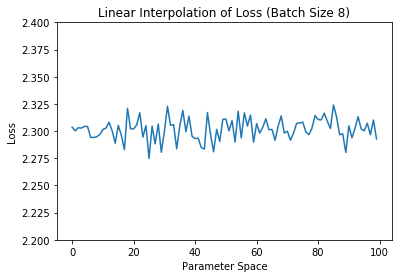

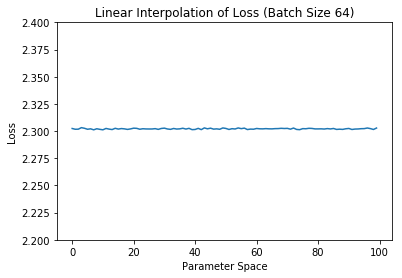

In [6]:
loss_data = loss_landscapes.compute.linear_interpolation(model_initial, model_final, make_evaluation(8))
plt.plot(loss_data)
plt.title('Linear Interpolation of Loss (Batch Size 8)')
plt.xlabel('Parameter Space')
plt.ylabel('Loss')
axes = plt.gca()
axes.set_ylim([2.2,2.4])
plt.show()

loss_data = loss_landscapes.compute.linear_interpolation(model_initial, model_final, make_evaluation(64))
plt.plot(loss_data)
plt.title('Linear Interpolation of Loss (Batch Size 64)')
plt.xlabel('Parameter Space')
plt.ylabel('Loss')
axes = plt.gca()
axes.set_ylim([2.2,2.4])
plt.show()

A linear interpolation plot, as seen above, computes the model's loss at discrete intervals along a line between two points in parameter space. A common use for such a plot is computing the loss along the "straight line path" from the model's initialization to the model's final (trained) parameters, as we have done here. Observe that with larger batch sizes, the loss is smoother. This is because a larger batch suppresses the variations in the model's performance on individual samples. Note that there is no guarantee that the model followed this path during training.

Next we will make some contour plots, both around the initial parameters and around the final parameters.

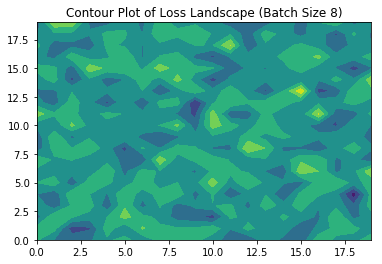

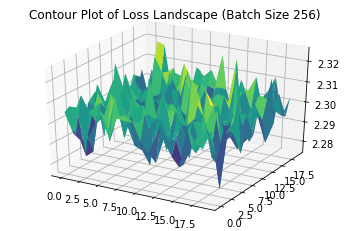

In [7]:
loss_data = loss_landscapes.compute.random_plane(model_initial, make_evaluation(8), steps = 20)
plt.contourf(loss_data)
plt.title('Contour Plot of Loss Landscape (Batch Size 8)')
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(20)] for i in range(20)])
Y = np.array([[i for _ in range(20)] for i in range(20)])
ax.plot_surface(X, Y, loss_data, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Contour Plot of Loss Landscape (Batch Size 8)');

And since we're feeling fancy, let's make a surface plot as well!

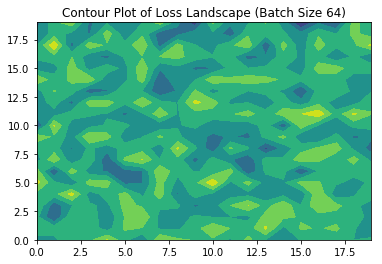

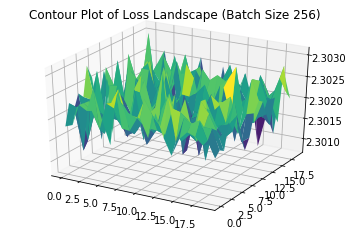

In [8]:
loss_data = loss_landscapes.compute.random_plane(model_initial, make_evaluation(64), steps = 20)
plt.contourf(loss_data)
plt.title('Contour Plot of Loss Landscape (Batch Size 64)')
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(20)] for i in range(20)])
Y = np.array([[i for _ in range(20)] for i in range(20)])
ax.plot_surface(X, Y, loss_data, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Contour Plot of Loss Landscape (Batch Size 64)');

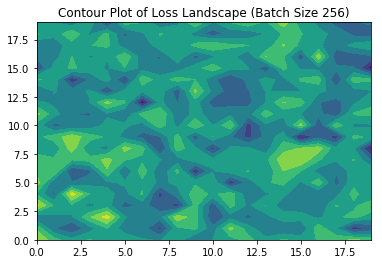

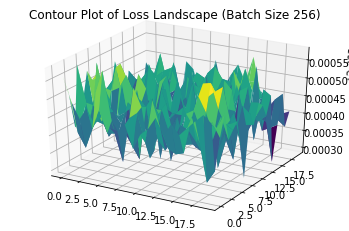

In [9]:
loss_data = loss_landscapes.compute.random_plane(model_initial, make_evaluation(256), steps = 20)
plt.contourf(loss_data)
plt.title('Contour Plot of Loss Landscape (Batch Size 256)')
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(20)] for i in range(20)])
Y = np.array([[i for _ in range(20)] for i in range(20)])
ax.plot_surface(X, Y, loss_data, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Contour Plot of Loss Landscape (Batch Size 256)');